# Batch Normalization（批归一化）

## 概述和原理

在深度神经网络中，每一层的输入数据分布可能会随着训练的进行而变化，这被称为**内部协变量偏移**（Internal Covariate Shift）。Batch Normalization的核心思想就是对每个批次的输入数据进行归一化，使其均值为0，方差为1，从而减少内部协变量偏移。

Batch Normalization的计算过程如下：
1. 对每个小批次的输入数据计算均值和方差。
2. 使用批次的均值和方差对输入数据进行标准化，得到零均值和单位方差的数据。
3. 使用可学习的缩放因子和偏移项对标准化后的数据进行线性变换，从而使网络能够学习适合的平均值和方差。

## Batch Normalization的优势

1. **加速收敛：** Batch Normalization有助于加速网络的收敛速度，减少梯度消失问题，使网络在早期阶段就能够学到有效的特征。
2. **增强稳定性：** Batch Normalization可以增强网络的稳定性，使网络对超参数的选择不太敏感，从而更容易进行训练。
3. **减少过拟合：** Batch Normalization在一定程度上可以充当正则化的作用，减少模型的过拟合风险。
4. **允许较大的学习率：** 由于Batch Normalization减少了梯度的变化范围，因此可以使用较大的学习率，加快训练过程。

- ```没必要和dropout混用```




## Batch Normalization 公式
假设我们有一个批次（batch）的输入数据 $X$，维度为 $(\text{batch\_size}, \text{num\_features})$，其中 $\text{batch\_size}$ 是批次大小，$\text{num\_features}$ 是输入特征的数量。

- 1. 计算批次的均值（mean）和方差（variance）：
   $$\mu_B = \frac{1}{\text{batch\_size}} \sum_{i=1}^{\text{batch\_size}} X_{i}$$
   $$\sigma_B^2 = \frac{1}{\text{batch\_size}} \sum_{i=1}^{\text{batch\_size}} (X_{i} - \mu_B)^2$$

- 2. 标准化输入数据：
   $$\hat{X}_i = \frac{X_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
   其中，$\epsilon$ 是一个小的正数，用于防止除以零。

- 3. 缩放和平移：
   $$Y_i = \gamma \hat{X}_i + \beta$$
   其中，$\gamma$ 和 $\beta$ 是可学习的参数，用于缩放和平移标准化后的数据。

在训练过程中，$\mu_B$ 和 $\sigma_B^2$ 是根据每个批次的数据计算得到的。在测试阶段，可以使用移动平均或固定的统计数据来计算 $\mu_B$ 和 $\sigma_B^2$

这些操作将使得输入数据的均值为0，方差为1，从而减少了内部协变量偏移，提升了训练稳定性和收敛速度

公式中的 $\gamma$ 和 $\beta$ 是可学习的参数，它们允许网络在训练过程中学习合适的缩放和平移，从而适应不同任务的要求

## 详细实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """
    批归一化函数

    参数：
    X: 输入数据，形状为 (batch_size, num_features) 或 (batch_size, num_channels, height, width)
    gamma: 缩放因子，形状与输入数据的特征数或通道数相同
    beta: 平移项，形状与输入数据的特征数或通道数相同
    moving_mean: 移动平均均值，形状与输入数据的特征数或通道数相同
    moving_var: 移动平均方差，形状与输入数据的特征数或通道数相同
    eps: 一个小的正数，用于防止除以零
    momentum: 移动平均的动量

    返回：
    Y: 批归一化后的输出，与输入数据的形状相同
    moving_mean: 更新后的移动平均均值
    moving_var: 更新后的移动平均方差
    """
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        # 使用全连接层的情况
        if len(X.shape) == 2:
            # 按行求均值
            mean = X.mean(dim=0)
            # 按行求方差
            var = ((X - mean) ** 2).mean(dim=0)
        # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
        else:
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [3]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代(放在nn.Parameter)的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上(因为没有放在nn.Parameter)
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 使用批量归一化层的 LeNet

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.270, train acc 0.900, test acc 0.867
4886.7 examples/sec on cpu


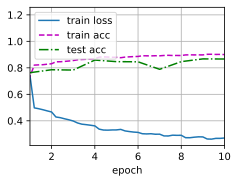

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.7488, 2.6666, 3.0989, 3.3460, 1.1231, 2.4089],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 2.4273, -2.8331, -2.3274, -1.5441, -1.2047, -1.8088],
        grad_fn=<ReshapeAliasBackward0>))

## 简洁实现

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.263, train acc 0.902, test acc 0.840
9649.6 examples/sec on cpu


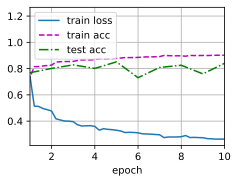

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())